Note:  
This notebook was executed on google colab pro.

In [1]:
!pip3 install pytorch-lightning timm --quiet

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/atmacup11/experiments')

# Settings

In [4]:
EXP_NO = 28
SEED = 1
N_SPLITS = 5
TARGET = 'target'
GROUP = 'art_series_id'
REGRESSION = False

In [5]:
assert((TARGET, REGRESSION) in (('target', True), ('target', False), ('sorting_date', True)))

In [6]:
MODEL_NAME = 'efficientnet_b0'
BATCH_SIZE = 128
NUM_EPOCHS = 300

# Library

In [7]:
from collections import defaultdict
from functools import partial
import gc
import glob
import json
from logging import getLogger, StreamHandler, FileHandler, DEBUG, Formatter
import pickle
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, mean_squared_error, cohen_kappa_score
# from sklearnex import patch_sklearn
from pytorch_lightning import seed_everything
import timm
import torch
import torch.nn as nn
import torch.optim
from torch.utils.data import DataLoader
from torchvision import transforms

SCRIPTS_DIR = os.path.join('..', 'scripts')
assert(os.path.isdir(SCRIPTS_DIR))
if SCRIPTS_DIR not in sys.path: sys.path.append(SCRIPTS_DIR)

from cross_validation import load_cv_object_ids
from dataset import load_csvfiles, load_photofile,load_photofiles, AtmaImageDatasetV02
from folder import experiment_dir_of
from models import initialize_model
from utils import train_model, predict_by_model

In [8]:
pd.options.display.float_format = '{:.5f}'.format

In [9]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

# Prepare directory

In [10]:
output_dir = experiment_dir_of(EXP_NO)

In [11]:
output_dir

'../scripts/../experiments/exp028'

# Prepare logger

In [12]:
logger = getLogger(__name__)

In [13]:
'''Refference
https://docs.python.org/ja/3/howto/logging-cookbook.html
'''
logger.setLevel(DEBUG)
# create file handler which logs even debug messages
fh = FileHandler(os.path.join(output_dir, 'log.log'))
fh.setLevel(DEBUG)
# create console handler with a higher log level
ch = StreamHandler()
ch.setLevel(DEBUG)
# create formatter and add it to the handlers
formatter = Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(fh)
logger.addHandler(ch)
len(logger.handlers)

2

In [14]:
logger.info('Experiment no: {}'.format(EXP_NO))
logger.info('CV: StratifiedGroupKFold')
logger.info('SEED: {}'.format(SEED))
logger.info('REGRESSION: {}'.format(REGRESSION))

2021-07-22 03:53:39,924 - __main__ - INFO - Experiment no: 28
2021-07-22 03:53:39,927 - __main__ - INFO - CV: StratifiedGroupKFold
2021-07-22 03:53:39,930 - __main__ - INFO - SEED: 1
2021-07-22 03:53:39,932 - __main__ - INFO - REGRESSION: False


# Load csv files

In [15]:
SINCE = time.time()

In [16]:
logger.debug('Start loading csv files ({:.3f} seconds passed)'.format(time.time() - SINCE))
train, test, materials, techniques, sample_submission = load_csvfiles()
logger.debug('Complete loading csv files ({:.3f} seconds passed)'.format(time.time() - SINCE))

2021-07-22 03:53:39,951 - __main__ - DEBUG - Start loading csv files (0.008 seconds passed)
2021-07-22 03:53:39,989 - __main__ - DEBUG - Complete loading csv files (0.046 seconds passed)


In [17]:
train

,object_id,sorting_date,art_series_id,target
0,002bff09b09998d0be65,1631,509357f67692a6a45626,1
1,00309fb1ef05416f9c1f,1900,7987b47bbe5dc3039179,3
2,003a1562e97f79ba96dc,1834,ded7c3c9636708e5b14c,3
3,004890880e8e7431147b,1743,582ac2d7f0cef195b605,2
4,00718c32602425f504c1,1885,64c907f0c08dce4fb8e8,3
...,...,...,...,...
3932,ffa3259fff8e6f3818a1,1850,b187c294b0550acf049a,3
3933,ffd4d361756587883e48,1670,ad49a044770a48f860a6,1
3934,ffd794b7b311b7b7fd92,1789,f030a01b480b18a27be2,2
3935,ffe49bba69d06446de7e,1805,f5287bc84a05aada1d17,3


In [18]:
test

,object_id
0,0009e50b94be36ccad39
1,000bd5e82eb22f199f44
2,0015f44de1854f617516
3,00388a678879ba1efa27
4,005e1e7c6496902d23f3
...,...
5914,ffbe65ad399b632dcbd0
5915,ffd7b2d646c0320c311a
5916,ffdb93ede17d4501e530
5917,ffe111402004b0ed46b4


# Cross validation

In [19]:
seed_everything(SEED)

Global seed set to 1


1

In [20]:
train.set_index('object_id', inplace=True)

2021-07-22 03:53:40,294 - __main__ - DEBUG - Start fold 1 (0.351 seconds passed)
2021-07-22 03:53:40,302 - __main__ - DEBUG - Start training model (0.359 seconds passed)
2021-07-22 03:53:43,160 - __main__ - DEBUG - Epoch 0/299
2021-07-22 03:53:55,155 - __main__ - DEBUG - train Loss: 0.5752
2021-07-22 03:53:57,416 - __main__ - DEBUG - val Loss: 0.5597
2021-07-22 03:53:57,451 - __main__ - DEBUG - Epoch 1/299
2021-07-22 03:54:09,456 - __main__ - DEBUG - train Loss: 0.5438
2021-07-22 03:54:11,738 - __main__ - DEBUG - val Loss: 0.5248
2021-07-22 03:54:11,773 - __main__ - DEBUG - Epoch 2/299
2021-07-22 03:54:23,750 - __main__ - DEBUG - train Loss: 0.5277
2021-07-22 03:54:26,067 - __main__ - DEBUG - val Loss: 0.6875
2021-07-22 03:54:26,069 - __main__ - DEBUG - Epoch 3/299
2021-07-22 03:54:38,023 - __main__ - DEBUG - train Loss: 0.5188
2021-07-22 03:54:40,312 - __main__ - DEBUG - val Loss: 0.5058
2021-07-22 03:54:40,350 - __main__ - DEBUG - Epoch 4/299
2021-07-22 03:54:52,296 - __main__ - DEBU

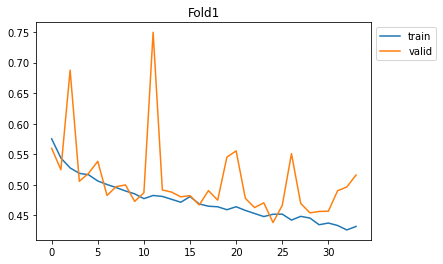

2021-07-22 04:01:57,372 - __main__ - DEBUG - Complete prediction for train fold (497.429 seconds passed)
2021-07-22 04:01:59,707 - __main__ - DEBUG - Complete prediction for val fold (499.764 seconds passed)
2021-07-22 04:07:37,318 - __main__ - DEBUG - Complete prediction for test fold (837.375 seconds passed)
2021-07-22 04:07:37,351 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp028/cv_fold1_training.csv (837.408 seconds passed)
2021-07-22 04:07:37,363 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp028/cv_fold1_validation.csv (837.420 seconds passed)
2021-07-22 04:07:37,409 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp028/cv_fold1_test.csv (837.466 seconds passed)
2021-07-22 04:07:37,514 - __main__ - DEBUG - Save model ../scripts/../experiments/exp028/cv_fold1_model.torch (837.571 seconds passed)
2021-07-22 04:07:37,604 - __main__ - DEBUG - Complete fold 1 (837.661 seconds passed)
2021-07-22 04:07:37,607 - __mai

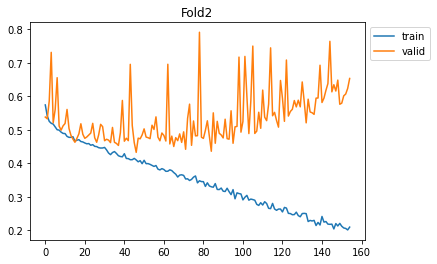

2021-07-22 04:44:44,212 - __main__ - DEBUG - Complete prediction for train fold (3064.269 seconds passed)
2021-07-22 04:44:46,453 - __main__ - DEBUG - Complete prediction for val fold (3066.511 seconds passed)
2021-07-22 04:44:59,145 - __main__ - DEBUG - Complete prediction for test fold (3079.202 seconds passed)
2021-07-22 04:44:59,176 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp028/cv_fold2_training.csv (3079.233 seconds passed)
2021-07-22 04:44:59,190 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp028/cv_fold2_validation.csv (3079.247 seconds passed)
2021-07-22 04:44:59,236 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp028/cv_fold2_test.csv (3079.293 seconds passed)
2021-07-22 04:44:59,348 - __main__ - DEBUG - Save model ../scripts/../experiments/exp028/cv_fold2_model.torch (3079.405 seconds passed)
2021-07-22 04:44:59,444 - __main__ - DEBUG - Complete fold 2 (3079.501 seconds passed)
2021-07-22 04:44:59,447

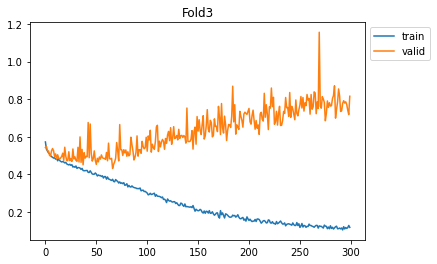

2021-07-22 05:56:49,763 - __main__ - DEBUG - Complete prediction for train fold (7389.820 seconds passed)
2021-07-22 05:56:52,042 - __main__ - DEBUG - Complete prediction for val fold (7392.099 seconds passed)
2021-07-22 05:57:05,157 - __main__ - DEBUG - Complete prediction for test fold (7405.215 seconds passed)
2021-07-22 05:57:05,191 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp028/cv_fold3_training.csv (7405.248 seconds passed)
2021-07-22 05:57:05,205 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp028/cv_fold3_validation.csv (7405.262 seconds passed)
2021-07-22 05:57:05,250 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp028/cv_fold3_test.csv (7405.307 seconds passed)
2021-07-22 05:57:05,353 - __main__ - DEBUG - Save model ../scripts/../experiments/exp028/cv_fold3_model.torch (7405.410 seconds passed)
2021-07-22 05:57:05,460 - __main__ - DEBUG - Complete fold 3 (7405.517 seconds passed)
2021-07-22 05:57:05,464

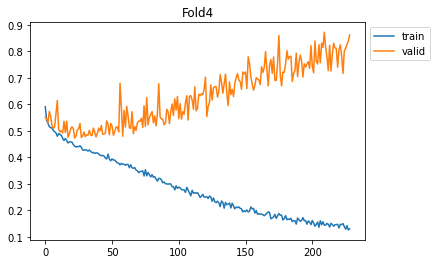

2021-07-22 06:52:23,262 - __main__ - DEBUG - Complete prediction for train fold (10723.319 seconds passed)
2021-07-22 06:52:25,548 - __main__ - DEBUG - Complete prediction for val fold (10725.605 seconds passed)
2021-07-22 06:52:38,392 - __main__ - DEBUG - Complete prediction for test fold (10738.449 seconds passed)
2021-07-22 06:52:38,425 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp028/cv_fold4_training.csv (10738.482 seconds passed)
2021-07-22 06:52:38,437 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp028/cv_fold4_validation.csv (10738.494 seconds passed)
2021-07-22 06:52:38,486 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp028/cv_fold4_test.csv (10738.543 seconds passed)
2021-07-22 06:52:38,595 - __main__ - DEBUG - Save model ../scripts/../experiments/exp028/cv_fold4_model.torch (10738.652 seconds passed)
2021-07-22 06:52:38,712 - __main__ - DEBUG - Complete fold 4 (10738.769 seconds passed)
2021-07-22 06:5

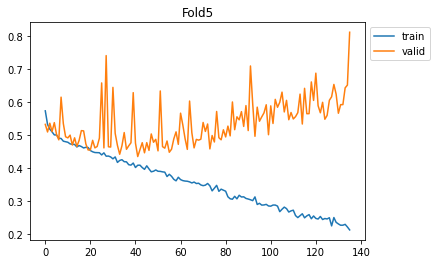

2021-07-22 07:25:34,741 - __main__ - DEBUG - Complete prediction for train fold (12714.798 seconds passed)
2021-07-22 07:25:37,065 - __main__ - DEBUG - Complete prediction for val fold (12717.123 seconds passed)
2021-07-22 07:25:50,183 - __main__ - DEBUG - Complete prediction for test fold (12730.240 seconds passed)
2021-07-22 07:25:50,217 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp028/cv_fold5_training.csv (12730.274 seconds passed)
2021-07-22 07:25:50,230 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp028/cv_fold5_validation.csv (12730.288 seconds passed)
2021-07-22 07:25:50,275 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp028/cv_fold5_test.csv (12730.332 seconds passed)
2021-07-22 07:25:50,376 - __main__ - DEBUG - Save model ../scripts/../experiments/exp028/cv_fold5_model.torch (12730.433 seconds passed)
2021-07-22 07:25:50,498 - __main__ - DEBUG - Complete fold 5 (12730.555 seconds passed)


In [21]:
fold_object_ids = load_cv_object_ids()
for i, (train_object_ids, valid_object_ids) in enumerate(zip(fold_object_ids[0], fold_object_ids[1])):
    assert(set(train_object_ids) & set(valid_object_ids) == set())
    num_fold = i + 1
    logger.debug('Start fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

    # Separate dataset into training/validation fold
    y_train = train.loc[train_object_ids, TARGET].values
    y_valid = train.loc[valid_object_ids, TARGET].values

    torch.cuda.empty_cache()
    
    # Training
    logger.debug('Start training model ({:.3f} seconds passed)'.format(time.time() - SINCE))
    ## Prepare model
    num_classes = len(set(list(y_train)))
    input_size = 224
    model = timm.create_model(MODEL_NAME, pretrained=False)
    model.classifier = nn.Sequential(
        nn.Linear(in_features=1280, out_features=32, bias=True),
        nn.Dropout(0.2),
        nn.Linear(in_features=32, out_features=num_classes, bias=True)
    )
    model.to(DEVICE)
    ## Prepare transformers
    train_transformer = transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    val_transformer = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    # Prepare dataset
    if not REGRESSION:
        # label should be one-hot style
        y_train = np.identity(num_classes)[y_train].astype('int')
        y_valid = np.identity(num_classes)[y_valid].astype('int')
    train_dataset = AtmaImageDatasetV02(train_object_ids, train_transformer, y_train)
    val_dataset = AtmaImageDatasetV02(valid_object_ids, val_transformer, y_valid)
    # Prepare dataloader
    dataloaders = {
        'train': DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count()),
        'val': DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count()),
    }
    ## train estimator
    estimator, train_losses, valid_losses = train_model(
        model, dataloaders, criterion=nn.BCEWithLogitsLoss(), num_epochs=NUM_EPOCHS, device=DEVICE,
        optimizer=torch.optim.Adam(model.parameters()), log_func=logger.debug,
        is_inception=MODEL_NAME == 'inception')
    logger.debug('Complete training ({:.3f} seconds passed)'.format(time.time() - SINCE))
    ## Visualize training loss
    plt.plot(train_losses, label='train')
    plt.plot(valid_losses, label='valid')
    plt.legend(loc='upper left', bbox_to_anchor=[1., 1.])
    plt.title(f'Fold{num_fold}')
    plt.show()
    
    # Save model and prediction
    ## Prediction
    predictions = {}
    for fold_, object_ids_ in zip(['train', 'val', 'test'],
                                  [train_object_ids, valid_object_ids, test['object_id']]):
        # Prepare transformer
        transformer_ = transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        # Prepare dataset
        dataset_ = AtmaImageDatasetV02(object_ids_, transformer_)
        # Prepare dataloader
        dataloader_ = DataLoader(dataset=dataset_, batch_size=BATCH_SIZE, shuffle=False,
                                 num_workers=os.cpu_count())
        # Prediction
        predictions[fold_] = predict_by_model(estimator, dataloader_, DEVICE)
        logger.debug('Complete prediction for {} fold ({:.3f} seconds passed)' \
                     .format(fold_, time.time() - SINCE))
    if REGRESSION:
        pred_train = pd.DataFrame(data=predictions['train'], columns=['pred'])
        pred_valid = pd.DataFrame(data=predictions['val'], columns=['pred'])
        pred_test = pd.DataFrame(data=predictions['test'], columns=['pred'])
    else:
        columns = list(range(num_classes))
        pred_train = pd.DataFrame(data=predictions['train'], columns=columns)
        pred_valid = pd.DataFrame(data=predictions['val'], columns=columns)
        pred_test = pd.DataFrame(data=predictions['test'], columns=columns)
    # else:  # Do not come here!
    #     raise NotImplemented
        # try:
        #     pred_train = pd.DataFrame(data=estimator.predict_proba(X_train),
        #                               columns=estimator.classes_)
        #     pred_valid = pd.DataFrame(data=estimator.predict_proba(X_valid),
        #                               columns=estimator.classes_)
        #     pred_test = pd.DataFrame(data=estimator.predict_proba(X_test),
        #                              columns=estimator.classes_)
        # except AttributeError:
        #     pred_train = pd.DataFrame(data=estimator.decision_function(X_train),
        #                               columns=estimator.classes_)
        #     pred_valid = pd.DataFrame(data=estimator.decision_function(X_valid),
        #                               columns=estimator.classes_)
        #     pred_test = pd.DataFrame(data=estimator.decision_function(X_test),
        #                              columns=estimator.classes_)
    ## Training set
    pred_train['object_id'] = train_object_ids
    filepath_fold_train = os.path.join(output_dir, f'cv_fold{num_fold}_training.csv')
    pred_train.to_csv(filepath_fold_train, index=False)
    logger.debug('Save training fold to {} ({:.3f} seconds passed)' \
                .format(filepath_fold_train, time.time() - SINCE))
    ## Validation set
    pred_valid['object_id'] = valid_object_ids
    filepath_fold_valid = os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv')
    pred_valid.to_csv(filepath_fold_valid, index=False)
    logger.debug('Save validation fold to {} ({:.3f} seconds passed)' \
                .format(filepath_fold_valid, time.time() - SINCE))
    ## Test set
    pred_test['object_id'] = test['object_id'].values
    filepath_fold_test = os.path.join(output_dir, f'cv_fold{num_fold}_test.csv')
    pred_test.to_csv(filepath_fold_test, index=False)
    logger.debug('Save test result {} ({:.3f} seconds passed)' \
                 .format(filepath_fold_test, time.time() - SINCE))
    ## Model
    filepath_fold_model = os.path.join(output_dir, f'cv_fold{num_fold}_model.torch')
    torch.save(estimator.state_dict(), filepath_fold_model)
#     with open(filepath_fold_model, 'wb') as f:
#         pickle.dump(estimator, f)
    logger.debug('Save model {} ({:.3f} seconds passed)'.format(filepath_fold_model, time.time() - SINCE))
    
    # Save memory
    del (estimator, y_train, y_valid, pred_train, pred_valid, pred_test)
    gc.collect()

    logger.debug('Complete fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

# Evaluation

In [22]:
rmse = partial(mean_squared_error, squared=False)

In [23]:
# qwk = partial(cohen_kappa_score, labels=np.sort(train['target'].unique()), weights='quadratic')

In [24]:
@np.vectorize
def predict(proba_0: float, proba_1: float, proba_2: float, proba_3: float) -> int:
    return np.argmax((proba_0, proba_1, proba_2, proba_3))

In [25]:
metrics = defaultdict(list)

## Training set

In [26]:
pred_train_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    logger.debug('Evaluate cv result (training set) Fold {}'.format(num_fold))
    # Read cv result
    filepath_fold_train = os.path.join(output_dir, f'cv_fold{num_fold}_training.csv')
    pred_train_df = pd.read_csv(filepath_fold_train)
    pred_train_df['actual'] = train.loc[pred_train_df['object_id'], TARGET].values
    if REGRESSION:
        if TARGET == 'target':
            pred_train_df['pred'].clip(lower=0, upper=3, inplace=True)
        else:
            pred_train_df['pred'] = np.vectorize(soring_date2target)(pred_train_df['pred'])
            pred_train_df['actual'] = np.vectorize(soring_date2target)(pred_train_df['actual'])
    else:
        pred_train_df['pred'] = predict(pred_train_df['0'], pred_train_df['1'],
                                        pred_train_df['2'], pred_train_df['3'])
    if not (REGRESSION and TARGET == 'target'):
        print(confusion_matrix(pred_train_df['actual'], pred_train_df['pred'],
                               labels=np.sort(train['target'].unique())))
    loss = rmse(pred_train_df['actual'], pred_train_df['pred'])
#     score = qwk(pred_train_df['actual'], pred_train_df['pred'])
    logger.debug('Loss: {}'.format(loss))
#     logger.debug('Score: {}'.format(score))
    metrics['train_losses'].append(loss)
#     metrics['train_scores'].append(score)
    pred_train_dfs.append(pred_train_df)

metrics['train_losses_avg'] = np.mean(metrics['train_losses'])
metrics['train_losses_std'] = np.std(metrics['train_losses'])
# metrics['train_scores_avg'] = np.mean(metrics['train_scores'])
# metrics['train_scores_std'] = np.std(metrics['train_scores'])

2021-07-22 07:25:50,576 - __main__ - DEBUG - Evaluate cv result (training set) Fold 1
2021-07-22 07:25:50,620 - __main__ - DEBUG - Loss: 0.8813351192121461
2021-07-22 07:25:50,622 - __main__ - DEBUG - Evaluate cv result (training set) Fold 2
2021-07-22 07:25:50,660 - __main__ - DEBUG - Loss: 0.7950336195311187
2021-07-22 07:25:50,663 - __main__ - DEBUG - Evaluate cv result (training set) Fold 3
2021-07-22 07:25:50,700 - __main__ - DEBUG - Loss: 0.713036267060985
2021-07-22 07:25:50,701 - __main__ - DEBUG - Evaluate cv result (training set) Fold 4
2021-07-22 07:25:50,738 - __main__ - DEBUG - Loss: 0.88253643458819
2021-07-22 07:25:50,740 - __main__ - DEBUG - Evaluate cv result (training set) Fold 5
2021-07-22 07:25:50,782 - __main__ - DEBUG - Loss: 0.8393892618504146


[[113 107 102  47]
 [ 25 243 370  76]
 [  9  78 989 130]
 [ 10  43 296 502]]
[[202 108  41  33]
 [ 79 387 180  69]
 [ 36 122 905 152]
 [ 15  46 157 629]]
[[ 221   93   46   18]
 [  42  465  160   40]
 [  18  116 1002   65]
 [  19   48  183  611]]
[[147  89  88  58]
 [ 76 254 289  94]
 [ 16 128 947 146]
 [  5  27 260 528]]
[[174 102  60  51]
 [ 38 350 252  95]
 [ 29  86 955 115]
 [ 11  27 223 580]]


In [27]:
pred_train = pd.concat(pred_train_dfs).groupby('object_id').sum()
pred_train = pred_train / N_SPLITS
if not REGRESSION:
    pred_train['pred'] = predict(pred_train['0'], pred_train['1'], pred_train['2'], pred_train['3'])
pred_train['actual'] = train.loc[pred_train.index, TARGET].values
if REGRESSION and TARGET == 'sorting_date':
    pred_train['actual'] = np.vectorize(soring_date2target)(pred_train['actual'])
# for c in ('pred', 'actual'):
#     pred_train[c] = pred_train[c].astype('int')
pred_train

,0,1,2,3,actual,pred
object_id,,,,,,
002bff09b09998d0be65,-2.53050,1.07687,-1.72833,-3.12457,1,1
00309fb1ef05416f9c1f,-2.76670,-1.64158,-1.06812,0.43706,3,3
003a1562e97f79ba96dc,-3.94268,-3.05376,-2.00316,1.74602,3,3
004890880e8e7431147b,-0.90874,-0.27835,-0.92838,-2.43287,2,1
00718c32602425f504c1,-3.41143,-2.48629,-1.28994,1.05989,3,3
...,...,...,...,...,...,...
ffa3259fff8e6f3818a1,-2.87838,-1.79997,-1.13683,0.45288,3,3
ffd4d361756587883e48,-1.59310,0.30750,-0.90795,-2.38336,1,1
ffd794b7b311b7b7fd92,-3.14061,-1.87808,0.58546,-1.15504,2,2


In [28]:
if not (REGRESSION and TARGET == 'target'):
    print(confusion_matrix(pred_train['actual'], pred_train['pred'], labels=np.sort(train['target'].unique())))
loss = rmse(pred_train['actual'], pred_train['pred'])
# score = qwk(pred_train['actual'], pred_train['pred'])
metrics['train_loss'] = loss
# metrics['train_score'] = score
logger.info('Training loss: {}'.format(loss))
# logger.info('Training score: {}'.format(score))

2021-07-22 07:25:50,908 - __main__ - INFO - Training loss: 0.7214201555917895


[[ 243  128   68   36]
 [  50  494  276   76]
 [  13   97 1291  110]
 [   6   32  254  763]]


In [29]:
pred_train.to_csv(os.path.join(output_dir, 'prediction_train.csv'))
logger.debug('Write cv result to {}'.format(os.path.join(output_dir, 'prediction_train.csv')))

2021-07-22 07:25:50,954 - __main__ - DEBUG - Write cv result to ../scripts/../experiments/exp028/prediction_train.csv


## Validation set

In [30]:
pred_valid_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    logger.debug('Evaluate cv result (validation set) Fold {}'.format(num_fold))
    # Read cv result
    filepath_fold_valid = os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv')
    pred_valid_df = pd.read_csv(filepath_fold_valid)
    pred_valid_df['actual'] = train.loc[pred_valid_df['object_id'], TARGET].values
    if REGRESSION:
        if TARGET == 'target':
            pred_valid_df['pred'].clip(lower=0, upper=3, inplace=True)
        else:
            pred_valid_df['pred'] = np.vectorize(soring_date2target)(pred_valid_df['pred'])
            pred_valid_df['actual'] = np.vectorize(soring_date2target)(pred_valid_df['actual'])
    else:
        pred_valid_df['pred'] = predict(pred_valid_df['0'], pred_valid_df['1'],
                                        pred_valid_df['2'], pred_valid_df['3'])        
    
    if not (REGRESSION and TARGET == 'target'):
        print(confusion_matrix(pred_valid_df['actual'], pred_valid_df['pred'],
                               labels=np.sort(train['target'].unique())))
    loss = rmse(pred_valid_df['actual'], pred_valid_df['pred'])
#     score = qwk(pred_valid_df['actual'], pred_valid_df['pred'])
    logger.debug('Loss: {}'.format(loss))
#     logger.debug('Score: {}'.format(score))
    metrics['valid_losses'].append(loss)
#     metrics['valid_scores'].append(score)
    pred_valid_dfs.append(pred_valid_df)
    
metrics['valid_losses_avg'] = np.mean(metrics['valid_losses'])
metrics['valid_losses_std'] = np.std(metrics['valid_losses'])
# metrics['valid_scores_avg'] = np.mean(metrics['valid_scores'])
# metrics['valid_scores_std'] = np.std(metrics['valid_scores'])

2021-07-22 07:25:50,990 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 1
2021-07-22 07:25:51,006 - __main__ - DEBUG - Loss: 0.9209672510685589
2021-07-22 07:25:51,007 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 2
2021-07-22 07:25:51,024 - __main__ - DEBUG - Loss: 0.9443265204999739
2021-07-22 07:25:51,026 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 3
2021-07-22 07:25:51,042 - __main__ - DEBUG - Loss: 0.8772800312127006
2021-07-22 07:25:51,044 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 4
2021-07-22 07:25:51,060 - __main__ - DEBUG - Loss: 0.9813548414517372
2021-07-22 07:25:51,062 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 5
2021-07-22 07:25:51,083 - __main__ - DEBUG - Loss: 0.8992321749337013


[[ 26  36  32  12]
 [ 12  63  84  23]
 [  5  24 238  38]
 [  3  11  63 127]]
[[ 44  25  10  12]
 [ 20  70  63  28]
 [ 11  39 205  41]
 [  7  20  57 124]]
[[ 46  24  21   6]
 [ 18  94  62  15]
 [  9  46 213  42]
 [  4  23  54 113]]
[[ 30  21  20  22]
 [ 15  58  87  23]
 [  1  40 182  51]
 [  6   5  94 130]]
[[ 32  23  16  17]
 [ 13  66  60  22]
 [  4  29 248  45]
 [  5   7  74 128]]


In [31]:
pred_valid = pd.concat(pred_valid_dfs).groupby('object_id').sum()
pred_valid = pred_valid / N_SPLITS
if not REGRESSION:
    pred_valid['pred'] = predict(pred_valid['0'], pred_valid['1'], pred_valid['2'], pred_valid['3'])
pred_valid['actual'] = train.loc[pred_valid.index, TARGET].values
if REGRESSION and TARGET == 'sorting_date':
    pred_valid['actual'] = np.vectorize(soring_date2target)(pred_valid['actual'])
# for c in ('pred', 'actual'):
#     pred_valid[c] = pred_valid[c].astype('int')
pred_valid

,0,1,2,3,actual,pred
object_id,,,,,,
002bff09b09998d0be65,-0.57263,0.16170,-0.26056,-0.81908,1,1
00309fb1ef05416f9c1f,-0.63053,-0.33455,-0.48954,0.11709,3,3
003a1562e97f79ba96dc,-1.07138,-0.59626,-0.71077,0.41399,3,3
004890880e8e7431147b,-0.25078,0.09717,-0.35643,-0.71102,2,1
00718c32602425f504c1,-0.77035,-0.51093,0.12391,-0.20833,3,2
...,...,...,...,...,...,...
ffa3259fff8e6f3818a1,-0.53958,-0.29634,-0.10573,-0.07371,3,3
ffd4d361756587883e48,-0.08787,0.04922,-0.38307,-0.63092,1,1
ffd794b7b311b7b7fd92,-0.93910,-0.46539,0.07458,-0.13574,2,2


In [32]:
if not REGRESSION:
    print(confusion_matrix(pred_valid['actual'], pred_valid['pred'], labels=np.sort(train['target'].unique())))
loss = rmse(pred_valid['actual'], pred_valid['pred'])
# score = qwk(pred_valid['actual'], pred_valid['pred'])
metrics['valid_loss'] = loss
# metrics['valid_score'] = score
logger.info('Validatino loss: {}'.format(loss))
# logger.info('Validatino score: {}'.format(score))

2021-07-22 07:25:51,173 - __main__ - INFO - Validatino loss: 0.9251927971852266


[[ 178  129   99   69]
 [  78  351  356  111]
 [  30  178 1086  217]
 [  25   66  342  622]]


In [33]:
pred_valid.to_csv(os.path.join(output_dir, 'prediction_valid.csv'))
logger.debug('Write cv result to {}'.format(os.path.join(output_dir, 'prediction_valid.csv')))

2021-07-22 07:25:51,218 - __main__ - DEBUG - Write cv result to ../scripts/../experiments/exp028/prediction_valid.csv


In [34]:
with open(os.path.join(output_dir, 'metrics.json'), 'w') as f:
    json.dump(dict(metrics), f)
logger.debug('Write metrics to {}'.format(os.path.join(output_dir, 'metrics.json')))

2021-07-22 07:25:51,235 - __main__ - DEBUG - Write metrics to ../scripts/../experiments/exp028/metrics.json


# Prediction

In [35]:
pred_test_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    # Read cv result
    filepath_fold_test = os.path.join(output_dir, f'cv_fold{num_fold}_test.csv')
    pred_test_df = pd.read_csv(filepath_fold_test)
    pred_test_dfs.append(pred_test_df)

In [36]:
pred_test = pd.concat(pred_test_dfs).groupby('object_id').sum()
pred_test = pred_test / N_SPLITS
if REGRESSION:
    if TARGET == 'target':
        pred_test['pred'].clip(lower=0, upper=3, inplace=True)
    else:
        pred_test['pred'] = np.vectorize(soring_date2target)(pred_test['pred'])
else:
    pred_test['pred'] = predict(pred_test['0'], pred_test['1'], pred_test['2'], pred_test['3'])
pred_test

,0,1,2,3,pred
object_id,,,,,
0009e50b94be36ccad39,-2.20178,-0.06055,-1.12659,-2.11241,1
000bd5e82eb22f199f44,-2.23944,-0.92061,-1.04898,-0.86754,3
0015f44de1854f617516,-3.74969,-0.85761,0.46226,-3.63542,2
00388a678879ba1efa27,-3.50639,-2.05836,-0.14581,-0.95206,2
005e1e7c6496902d23f3,-0.45388,-0.29397,-1.72952,-3.23667,1
...,...,...,...,...,...
ffbe65ad399b632dcbd0,-3.17363,-2.29649,-1.83552,0.84977,3
ffd7b2d646c0320c311a,-2.98812,1.61311,-2.34512,-4.67245,1
ffdb93ede17d4501e530,-4.21576,-1.74446,1.33011,-3.32245,2


In [37]:
test['target'] = pred_test.loc[test['object_id'], 'pred'].values
test = test[['target']]
test

,target
0,1
1,3
2,2
3,2
4,1
...,...
5914,3
5915,1
5916,2
5917,2


In [38]:
sample_submission

,target
0,3
1,1
2,3
3,3
4,0
...,...
5914,2
5915,1
5916,1
5917,3


In [39]:
test.to_csv(os.path.join(output_dir, f'{str(EXP_NO).zfill(3)}_submission.csv'), index=False)
logger.debug('Write submission to {}'.format(os.path.join(output_dir, f'{str(EXP_NO).zfill(3)}_submission.csv')))

2021-07-22 07:25:51,441 - __main__ - DEBUG - Write submission to ../scripts/../experiments/exp028/028_submission.csv


2021-07-22 07:25:51,543 - __main__ - DEBUG - Write figure to ../scripts/../experiments/exp028/prediction.png


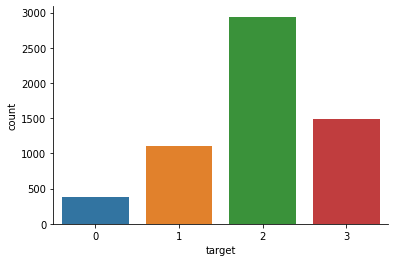

In [40]:
fig = plt.figure()
if not (REGRESSION and TARGET == 'target'):
    sns.countplot(data=test, x='target')
else:
    sns.histplot(data=test, x='target')
sns.despine()
fig.savefig(os.path.join(output_dir, 'prediction.png'))
logger.debug('Write figure to {}'.format(os.path.join(output_dir, 'prediction.png')))

In [41]:
logger.debug('Complete ({:.3f} seconds passed)'.format(time.time() - SINCE))

2021-07-22 07:25:51,680 - __main__ - DEBUG - Complete (12731.737 seconds passed)
